<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [68]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

import warnings
warnings.simplefilter('ignore')

from scipy.stats import bernoulli, beta # Beta es una distribución de 2 parámetros, por eso importamos. 

import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns

## Con AB test

In [2]:
df = pd.read_csv('./data/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
repes = df.userid.value_counts()
repes[repes>1] # No hay userid repetidos, xq no pueden estar en 2 grupos a la vez.

Series([], Name: userid, dtype: int64)

### AB test para retention_1

In [4]:
pd.crosstab(df.version, df.retention_1) # Aquí veo cuantos CONVERSTIDOS hay en cada grupo

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [5]:
df[df.version == 'gate_30']['userid'].count() # Cantidad de personas del grupo de control
df[df.version == 'gate_40']['userid'].count() # Cantidad de personas del grupo de tratamiento
df[(df.version == 'gate_30') & df.retention_1 == True]['userid'].count() # Cantidad de personas que convertimos del Gº Control
df[(df.version == 'gate_40') & df.retention_1 == True]['userid'].count() # Cantidad de personas que convertimos del Gº Tratam.

20119

In [6]:
imps_ctrl, convs_ctrl = 44700, 20034 # Total Gº Ctrl, Nº Convertidos Ctrl
imps_test, convs_test = 45489, 20119 # Total Gº Trat, Nº Convertidos Trat

CR_ctrl = convs_ctrl/imps_ctrl # Tasa de conversión del Gº de control
CR_test = convs_test/imps_test # Tasa de conversión del Gº de tratamiento

f'TASAS: Control={CR_ctrl}, Test={CR_test}' # De cada 100 que entran se convierten 44'XX %

'TASAS: Control=0.4481879194630872, Test=0.44228274967574577'

In [7]:
# A PRIORIS - OTRA FORMA DE HACERLO

a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1 # Para actualizar la Beta, a_C = Convertidos de control, b_C NO convertidos
a_T, b_T = convs_test+1, imps_test-convs_test+1 # a_T es CONVERTIDOS de Tratamiento, b_T NO convertidos de Tratamiento

beta_control=beta(a_C, b_C) # Beta del Gª control
beta_test=beta(a_T, b_T) # Beta del Gº Tratam.

beta_control.mean(), beta_test.mean() # Las medias de conversiones para cada grupo. De cada 100 que entran se convierten 44'XX %

(0.44819023757326293, 0.44228528719966587)

In [17]:
x=np.linspace(0.42, 0.47, 1000) # (Límite inferior para pintas, limite superior, puntos a pintar). Empezar en (0,1,1000)

def plot(betas, nombres): # Función para pintar, que le entran las betas y los nombres (la leyenda)
    
    for bet, nom in zip(betas, nombres): # Para cada beta, nombre en el dict de (betas, nombres)
        
        y=bet.pdf(x) # La función en sí mismo, es un punto concreto de la curva. Cada vuelta el bucle pinta otro punto.
        y_media=bet.mean() # Para la leyenda
        y_std=bet.std() # Para la leyenda
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std)) # x,y,lenda
        plt.yticks([]) # Quita los valores de las y
        
    plt.legend() # Pinta la leyenda
    plt.show(); # Muestra el gráfico

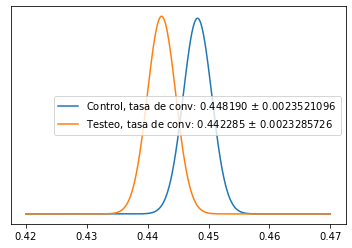

In [18]:
plot([beta_control, beta_test], ['Control', 'Testeo']) # Píntame beta de control y test con leyendas "Control" y "Testeo"

In [19]:
salto=(beta_test.mean() - beta_control.mean())/beta_control.mean() # Porcentaje en el que mejora/empeora la conversión

salto

-0.013175098158249857

In [20]:
from mpmath import betainc   # integral de beta

In [24]:
beta.cdf(0.445, a_T, b_T) # o prob=betainc(a_T, b_T, PuntoDeCorte, 1, regularized=True)

0.8781293616836622

In [22]:
prob=beta.cdf(0.445, a_T, b_T) # Área debajo del punto de corte. Área de la curva de Gº de Tratamiento (Testeo)

prob # Probabilidad de acertar en la predicción del AB testing.

0.8781293616836622

In [23]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test aumenta la tasa de conversion en un -1.32%, con una probabilidad del 87.81%'

### AB test para retention_7

In [25]:
pd.crosstab(df.version, df.retention_7)

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [26]:
imps_ctrl, convs_ctrl = 44700, 8502
imps_test, convs_test = 45489, 8279

CR_ctrl = convs_ctrl/imps_ctrl # Tasa de conversión del Gº de control
CR_test = convs_test/imps_test # Tasa de conversión del Gº de tratamiento

f'TASAS: Control={CR_ctrl}, Test={CR_test}'

'TASAS: Control=0.19020134228187918, Test=0.18200004396667327'

In [27]:
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
a_T, b_T = convs_test+1, imps_test-convs_test+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)

beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [35]:
x=np.linspace(0.165, 0.207, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

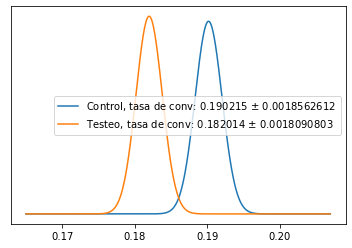

In [36]:
plot([beta_control, beta_test], ['Control', 'Testeo'])

In [30]:
salto=(beta_test.mean() - beta_control.mean())/beta_control.mean()

salto

-0.04311526114658881

In [31]:
prob=beta.cdf(0.186, a_T, b_T)
prob

0.9858653005312228

In [32]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test aumenta la tasa de conversion en un -4.31%, con una probabilidad del 98.59%'

## Lo hacemos frecuentista

### AB test frecuentista para retetion_1

In [39]:
df['version'].value_counts() # Saber cuantas observaciones hay de cada grupo.

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [40]:
pd.crosstab(df.version, df.retention_1) # Aquí esta tabla no hace falta. 

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [41]:
control = df[df.version=='gate_30'].sample(n=44700, random_state=42) # Me quedo con el nº de observaciones del menos grupo.

tratamiento = df[df.version=='gate_40'].sample(n=44700, random_state=42) # El 42 es una semilla para que el sample sea fijo

ab_test = pd.concat([control, tratamiento], axis=0) # Concateno los df filtrado para tener un df con las observaciones q quiero

ab_test.reset_index(drop=True, inplace=True) # Reseteo índices

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,6531033,gate_30,35,False,False
1,8003009,gate_30,4,False,False
2,5566807,gate_30,23,True,False
3,64235,gate_30,1,False,False
4,6210551,gate_30,7,False,False


In [43]:
ab_test['version'].value_counts() # Compruebo que ahora los grupos tienen las mismas observaciones

gate_30    44700
gate_40    44700
Name: version, dtype: int64

In [66]:
tasas_conversion = ab_test.groupby('version')['retention_1']  # agrupo por grupo y deja solo la columna retention


std=lambda x: np.std(x, ddof=0)    # saco la std
error_std=lambda x: stats.sem(x, ddof=0)   # saco el error standard , (std/sqrt(n))


tasas_conversion = tasas_conversion.agg([np.mean, std, error_std]) # cojo el df de arriba y le aplico las funciones []
tasas_conversion.columns = ['conversion_rate', 'std', 'std_error'] # renombro las columnas


tasas_conversion.style.format('{:.3f}') # Para quedarme con 3 decimales

,conversion_rate,std,std_error
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.443,0.497,0.002


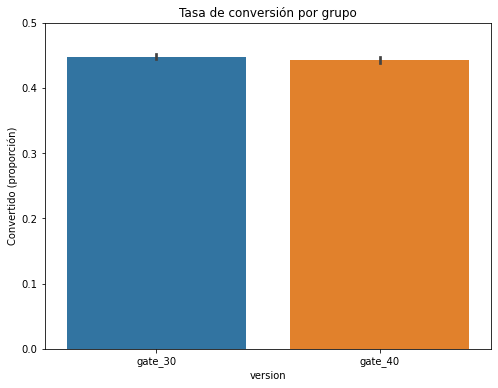

In [73]:
plt.figure(figsize=(8,6)) # Pinto el gráfico con dimensiones (8,6)

sns.barplot(x=ab_test['version'], # Las x con los grupos (control, y testeo)
            y=ab_test['retention_1']) 

plt.ylim(0, 0.5) # Marco los límites de la y
plt.title('Tasa de conversión por grupo') # Doy título al gráfico
plt.xlabel('version') # Doy nombre a las x
plt.ylabel('Convertido (proporción)'); # Doy nombre a las y

In [74]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint # importaciones para el z test

In [76]:
# seleccion de grupos

control_res = ab_test[ab_test.version =='gate_30']['retention_1'] # Filtro el df, quedándome con GºCtrl y col ret_1

trat_res = ab_test[ab_test.version == 'gate_40']['retention_1'] # Same, pero GºTrtm

In [77]:
observaciones = [44700, 44700]  #control_res.count()

conversiones=[control_res.sum(), trat_res.sum()]  # conversiones por grupo, suma los True (ojo)

z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones) # ZTest, con conversiones = suma de Trues


# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, 
                                                                            nobs=observaciones,
                                                                            alpha=0.05) # Para un IC del 95%

In [78]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 1.69
p-valor: 0.091
intervalo conf 95% para grupo control: [0.444, 0.453]
intervalo conf 95% para grupo tratamiento: [0.438, 0.447]


In [79]:
from scipy.stats import norm # Para pintara la curva de la normal

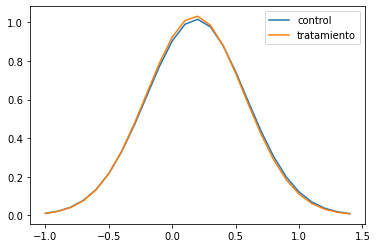

In [100]:
x=[i*.1 for i in range(-10, 15)]  # Ajusto los valores para que pinte bien el gráfico (las x)

control = [norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] # Para el eje x, pintar la curva

tratamiento = [norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control) # Píntame la curva
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']); # Ponme esta leyenda

In [ ]:
# Conclusiones: Para un IC del 95%, no podemos descartar la H0 de que los 2 grupos tienen comportamientos parecidos, por lo que
# diríamos que no hay diferencias significativas entre ellos, no surgiendo efecto el cambio.

### AB test frecuentista para retetion_7

In [82]:
df['version'].value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [83]:
pd.crosstab(df.version, df.retention_7)

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [85]:
tasas_conversion = ab_test.groupby('version')['retention_7']  # agrupo por grupo y deja solo la columna retention


std=lambda x: np.std(x, ddof=0)    # std
error_std=lambda x: stats.sem(x, ddof=0)   # error standard , (std/sqrt(n))


tasas_conversion = tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns = ['conversion_rate', 'std', 'std_error']


tasas_conversion.style.format('{:.3f}') # Para quedarme con 3 decimales

,conversion_rate,std,std_error
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


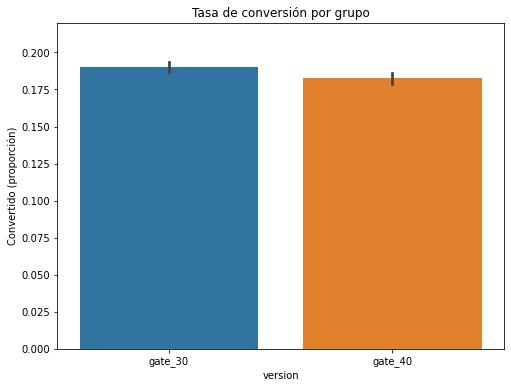

In [89]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_7'])

plt.ylim(0, 0.22)
plt.title('Tasa de conversión por grupo')
plt.xlabel('version')
plt.ylabel('Convertido (proporción)');

In [90]:
# seleccion de grupos

control_res = ab_test[ab_test.version =='gate_30']['retention_7']

trat_res=ab_test[ab_test.version == 'gate_40']['retention_7']

In [91]:
observaciones = [44700, 44700]  #control_res.count()

conversiones=[control_res.sum(), trat_res.sum()]  # conversiones por grupo

z_score, p_valor = proportions_ztest(conversiones, nobs=observaciones)


# intervalos de confianza

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, 
                                                                            nobs=observaciones,
                                                                            alpha=0.05)

In [92]:
print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_valor:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 2.98
p-valor: 0.003
intervalo conf 95% para grupo control: [0.187, 0.194]
intervalo conf 95% para grupo tratamiento: [0.179, 0.186]


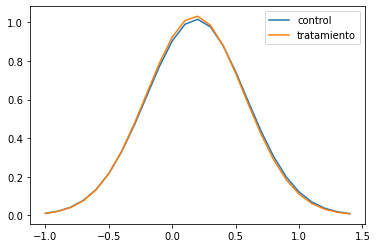

In [97]:
x=[i*.1 for i in range(-10, 15)]  

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

In [ ]:
# Conclusiones: Para un IC del 95%, hay diferencia de comportamiento entre los 2 grupos en retention_7. El cambio causa un 
# efecto, en este caso, negativo.  